#Imporing the data for training

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:05<00:00, 77.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


# importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import random
from glob import glob
from cv2 import cvtColor

  # Defining traing and test datasets paths

In [ ]:
train_path = '/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN'
test_path = '/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST'

#INSTALLING TENSORFLOW LIB

In [ ]:
!pip install tensorflow
!pip install opencv-python

# Importing TensorFlow and Keras

In [ ]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam

# Load training data for visualization


In [ ]:
x_data = []
y_data = []
for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split('/')[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████| 12565/12565 [00:05<00:00, 2377.75it/s]


In [ ]:
data.shape

(22564, 2)

#Analysing the Data in pie-chart

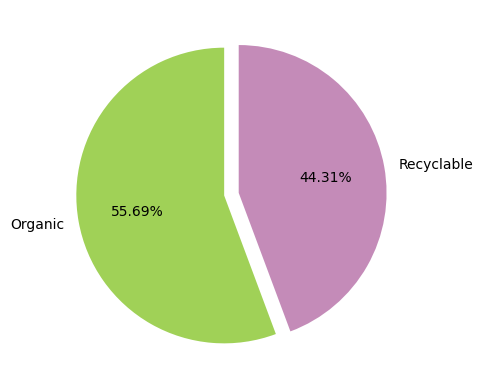

In [ ]:
colors = ['#a0d157', '#c48bb8']
plt.pie(
    data.label.value_counts(),
    labels=['Organic', 'Recyclable'],
    autopct='%0.2f%%',
    colors=colors,
    startangle=90,
    explode=[0.05, 0.05]
)
plt.show()

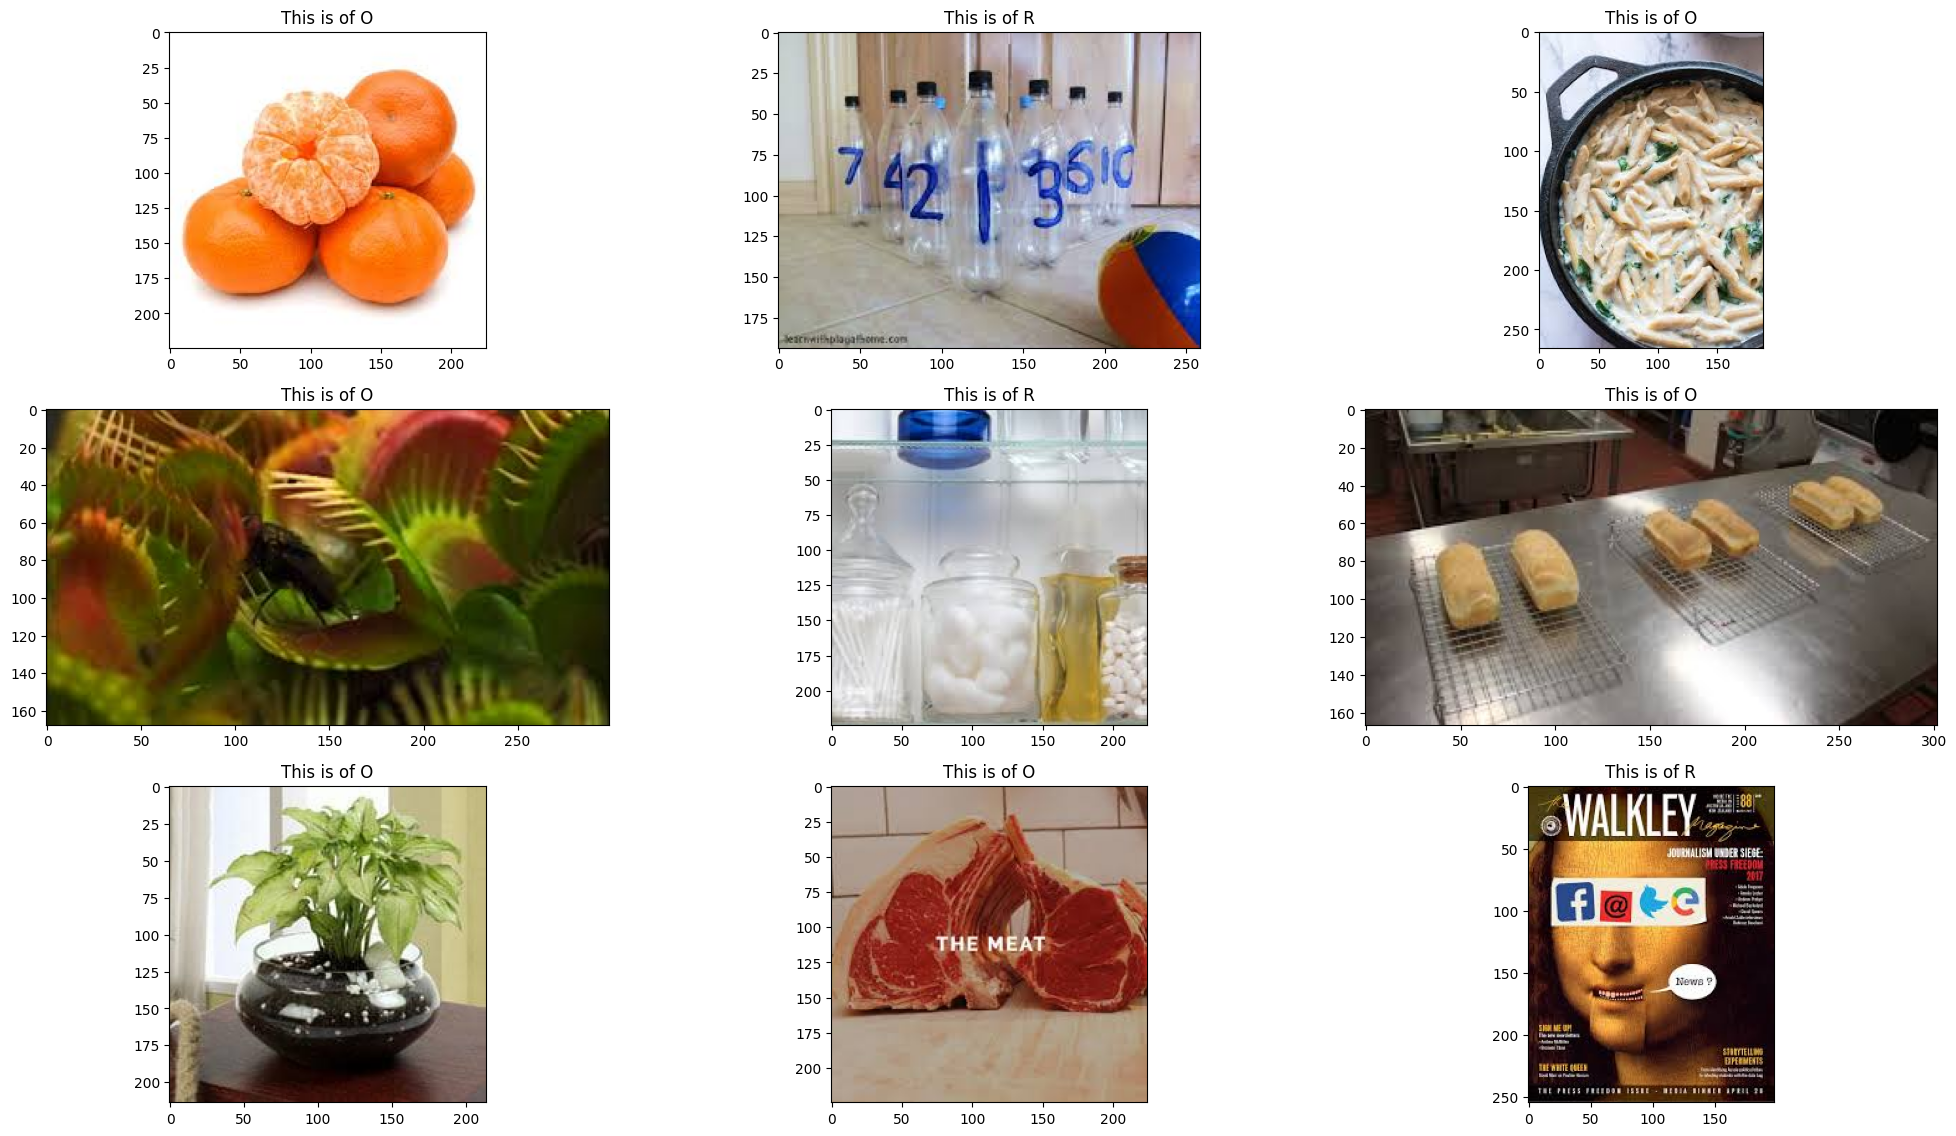

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3, (i % 12) + 1)
    index = np.random.randint(len(data))
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()
plt.show()

# Define Data Generators with stronger augmentation and VGG16 preprocessing


In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Load VGG16 base model (exclude top layers), freeze it


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Build custom top layers for classification


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

# Compile

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Train the top layers first

In [15]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)

Epoch 1/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 330s 449ms/step - accuracy: 0.8611 - loss: 2.9628 - val_accuracy: 0.8989 - val_loss: 0.3285
Epoch 2/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 303s 428ms/step - accuracy: 0.9154 - loss: 0.2531 - val_accuracy: 0.9053 - val_loss: 0.3764
Epoch 3/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 302s 428ms/step - accuracy: 0.9163 - loss: 0.2400 - val_accuracy: 0.9180 - val_loss: 0.2060
Epoch 4/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 301s 427ms/step - accuracy: 0.9061 - loss: 0.2558 - val_accuracy: 0.9339 - val_loss: 0.2309
Epoch 5/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 306s 433ms/step - accuracy: 0.9151 - loss: 0.2519 - val_accuracy: 0.9232 - val_loss: 0.3223


#  Optionally, unfreeze some deeper layers of VGG16 for fine-tuning

In [ ]:
# # (uncomment this block for an additional accuracy boost)
# """
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# model.compile(
#     loss="categorical_crossentropy",
#     optimizer=Adam(learning_rate=1e-4),
#     metrics=["accuracy"]
# )

# hist_finetune = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=test_generator
# )

# Plot accuracy

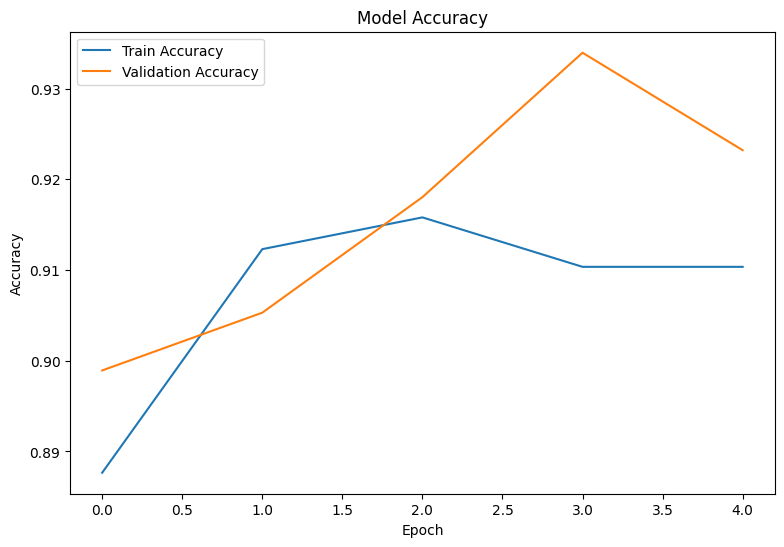

In [16]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on the test data

In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.9202 - loss: 0.3756
Test Loss: 0.32228654623031616, Test Accuracy: 0.9231993556022644


# save the model if performance is good


In [18]:
from tensorflow.keras.models import load_model

model.save('waste_classification_model.h5')